# Imports

In [1]:
#Imports
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import lightgbm as lgb
from scipy.stats import spearmanr

sns.set_style("white")
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
set_matplotlib_formats('svg')

plt.rcParams["font.family"] = "Times New Roman" # !!!!
plt.rcParams.update({'font.size': 32})


/tmp/ipykernel_1334/3791004227.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Loading Files

In [2]:
df_config = pd.read_csv("../data/train_mixture_1m.csv")
df_config = df_config.reindex(sorted(df_config.columns), axis=1)
df_config.head()

,index,train_slimpajama_arxiv,train_slimpajama_books,train_slimpajama_c4,train_slimpajama_commoncrawl,train_slimpajama_github,train_slimpajama_stackexchange,train_slimpajama_wikipedia
0,1,0.0058,0.0000,0.2208,0.0770,0.5568,0.1256,0.0140
1,2,0.0000,0.0000,0.6692,0.2956,0.0344,0.0002,0.0008
2,3,0.1688,0.5944,0.1310,0.0326,0.0688,0.0014,0.0030
3,4,0.0000,0.0466,0.0188,0.9308,0.0000,0.0038,0.0000
4,5,0.0346,0.0366,0.2232,0.3452,0.1050,0.0182,0.2372


In [4]:
df_wandb = pd.read_csv("../data/train_loss_1m.csv")
df_wandb = df_wandb.reindex(sorted(df_wandb.columns), axis=1)
df_wandb.head()


,index,metric/task_arc_challenge_val_loss,metric/task_arc_easy_val_loss,metric/task_commoncrawl_val_loss,metric/task_gsm8k_val_loss,metric/task_hellaswag_val_loss,metric/task_kodcode_val_loss,metric/task_logiqa_val_loss,metric/task_mathqa_val_loss,metric/task_medqa_val_loss,metric/task_piqa_val_loss,metric/task_sciq_val_loss
0,1,5.919474,6.030154,5.762697,6.134236,5.476267,3.309850,5.427458,6.439731,5.826575,5.732099,5.973314
1,2,5.573860,5.683704,5.314171,5.849506,5.213334,3.987117,5.066039,6.202672,5.208627,5.347432,5.506029
2,3,5.755280,5.865002,5.622282,6.022456,5.355449,3.559934,5.294124,6.335531,5.659749,5.556245,5.766811
3,4,5.589773,5.693293,5.251696,5.896199,5.508604,4.590811,5.137347,6.320046,5.231141,5.897509,5.527617
4,5,5.655616,5.756956,5.404464,5.878114,5.366104,3.655953,5.202996,6.280962,5.435903,5.625389,5.647578


In [5]:
X_train = df_config[df_config.columns[1:]].values
X_train.shape

(512, 7)

In [6]:
y_train = df_wandb[df_wandb.columns[1:]].values
y_train.shape

(512, 11)

In [7]:
df_config = pd.read_csv("../data/test_mixture_1m.csv")
df_config = df_config.reindex(sorted(df_config.columns), axis=1)
# df_config = df_config.head(105)
df_config

,index,train_slimpajama_arxiv,train_slimpajama_books,train_slimpajama_c4,train_slimpajama_commoncrawl,train_slimpajama_github,train_slimpajama_stackexchange,train_slimpajama_wikipedia
0,513,0.0000,0.0060,0.0000,0.9940,0.0000,0.0000,0.0000
1,514,0.4002,0.0000,0.0000,0.5998,0.0000,0.0000,0.0000
2,515,0.0184,0.0000,0.7178,0.1672,0.0966,0.0000,0.0000
3,516,0.0288,0.0020,0.1550,0.0646,0.6304,0.0138,0.1056
4,517,0.0024,0.1864,0.0728,0.6736,0.0044,0.0264,0.0344
...,...,...,...,...,...,...,...,...
251,764,0.0818,0.0000,0.1734,0.0050,0.7380,0.0018,0.0000
252,765,0.0212,0.0386,0.0156,0.7382,0.0484,0.1380,0.0000
253,766,0.0178,0.0000,0.1852,0.7910,0.0000,0.0000,0.0062
254,767,0.0068,0.4370,0.0236,0.3788,0.0116,0.0042,0.1380


In [8]:
df_wandb = pd.read_csv("../data/test_loss_1m.csv")
df_wandb = df_wandb.reindex(sorted(df_wandb.columns), axis=1)
df_wandb

,index,metric/task_arc_challenge_val_loss,metric/task_arc_easy_val_loss,metric/task_commoncrawl_val_loss,metric/task_gsm8k_val_loss,metric/task_hellaswag_val_loss,metric/task_kodcode_val_loss,metric/task_logiqa_val_loss,metric/task_mathqa_val_loss,metric/task_medqa_val_loss,metric/task_piqa_val_loss,metric/task_sciq_val_loss
0,513,5.653122,5.751509,5.261747,5.998609,5.566959,5.433196,5.158245,6.347327,5.270935,6.033068,5.558156
1,514,5.816751,5.914877,5.426983,6.030210,5.572977,4.985028,5.273109,6.345888,5.500072,6.180481,5.688911
2,515,5.536599,5.638042,5.365176,5.893193,5.190373,3.722421,5.079520,6.227895,5.263520,5.330527,5.529387
3,516,6.009850,6.119135,5.821479,6.206381,5.573943,3.376518,5.513866,6.462223,5.911592,5.874447,6.040687
4,517,5.571109,5.674881,5.268994,5.904662,5.376143,3.994658,5.123528,6.084455,5.267501,5.725760,5.527124
...,...,...,...,...,...,...,...,...,...,...,...,...
251,764,6.119586,6.262799,6.020448,6.298077,5.655901,3.341439,5.574873,6.577596,6.108341,5.906791,6.156691
252,765,5.660693,5.758520,5.333117,5.928816,5.476346,3.588841,5.196416,6.254467,5.322429,5.981575,5.602382
253,766,5.499625,5.595693,5.249883,5.888990,5.370731,5.073582,5.103650,6.137282,5.211947,5.568734,5.494660
254,767,5.598185,5.680414,5.320787,5.836723,5.450613,4.033094,5.193004,6.287665,5.362390,5.864896,5.589251


In [9]:
X_test = df_config[df_config.columns[1:]].values
X_test.shape


(256, 7)

In [10]:
y_test = df_wandb[df_wandb.columns[1:]].values
y_test.shape

(256, 11)

In [11]:
KEY_METRICS = df_wandb.columns[1:].tolist()
KEY_METRICS

['metric/task_arc_challenge_val_loss',
 'metric/task_arc_easy_val_loss',
 'metric/task_commoncrawl_val_loss',
 'metric/task_gsm8k_val_loss',
 'metric/task_hellaswag_val_loss',
 'metric/task_kodcode_val_loss',
 'metric/task_logiqa_val_loss',
 'metric/task_mathqa_val_loss',
 'metric/task_medqa_val_loss',
 'metric/task_piqa_val_loss',
 'metric/task_sciq_val_loss']

# Fitting

In [44]:
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1', 'l2'],
    "num_iterations": 1000,
    'seed': 42,
    'learning_rate': 1e-2,
    "verbosity": -1,
}

np.random.seed(42)

# Define the metrics to predict
commoncrawl_idx = KEY_METRICS.index('metric/task_commoncrawl_val_loss')

# Define all available reasoning task metrics
all_reasoning_metrics = {
    'gsm8k': 'metric/task_gsm8k_val_loss',
    'sciq': 'metric/task_sciq_val_loss',
    'arc_easy': 'metric/task_arc_easy_val_loss',
    'arc_challenge': 'metric/task_arc_challenge_val_loss',
    'hellaswag': 'metric/task_hellaswag_val_loss',
    'piqa': 'metric/task_piqa_val_loss',
    'logiqa': 'metric/task_logiqa_val_loss',
    'medqa': 'metric/task_medqa_val_loss',
    'mathqa': 'metric/task_mathqa_val_loss',
    'kodcode': 'metric/task_kodcode_val_loss'
}

# Create ablation configurations
ablation_configs = {
    'T1': {
        'name': 'gsm8k+arc_easy+arc_challenge',
        'metrics': ['gsm8k', 'arc_easy', 'arc_challenge']
    },
    'T2': {
        'name': 'gsm8k+hellaswag',
        'metrics': ['gsm8k', 'hellaswag']
    },
    'T3': {
        'name': 'gsm8k+piqa',
        'metrics': ['gsm8k', 'piqa']
    },
    'T4': {
        'name': 'gsm8k+logiqa',
        'metrics': ['gsm8k', 'logiqa']
    },
    'T5': {
        'name': 'gsm8k+sciq',
        'metrics': ['gsm8k', 'sciq']
    },
    'T6': {
        'name': 'gsm8k+kodcode+arc_easy+arc_challenge',
        'metrics': ['gsm8k', 'kodcode', 'arc_easy', 'arc_challenge']
    },
    'T7': {
        'name': 'gsm8k+kodcode+hellaswag',
        'metrics': ['gsm8k', 'kodcode', 'hellaswag']
    },
    'T8': {
        'name': 'all_tasks',
        'metrics': list(all_reasoning_metrics.keys())  # All 8 tasks
    },
    'T9': {
        'name': '6_tasks_without_kodcode_gsm8k',
        'metrics': ['sciq', 'arc_easy', 'arc_challenge', 'hellaswag', 'piqa', 'logiqa']
    },
    'T10': {
        'name': 'reasoning + mathqa + medqa',
        'metrics': ['sciq', 'arc_easy', 'arc_challenge', 'hellaswag', 'piqa', 'logiqa', 'mathqa', 'medqa']
    },
    'T11': {
        'name': 'arc + mathqa',
        'metrics': [ 'arc_easy', 'arc_challenge',  'medqa', 'mathqa']
    },
    'T12': {
        'name': 'hellaswag + logiqa + medqa + mathqa',
        'metrics': ['medqa', 'mathqa', 'hellaswag', 'logiqa']
    },

}

# Create a map from metrics to their indices
metric_to_idx = {metric: KEY_METRICS.index(metric_name) for metric, metric_name in all_reasoning_metrics.items()}


In [ ]:

# Function to compute average of selected reasoning tasks
def compute_reasoning_avg(X, task_list):
    indices = [metric_to_idx[task] for task in task_list]
    return np.mean([X[:, idx] for idx in indices], axis=0)

# Dictionary to store all trained models
all_predictors = {}

# Train commoncrawl model
print("Training Commoncrawl model...")
target = y_train[:, commoncrawl_idx]
test_target = y_test[:, commoncrawl_idx]

gbm = lgb.LGBMRegressor(**hyper_params)

reg = gbm.fit(X_train, target,
    eval_set=[(X_test, test_target)],
    eval_metric='l2', callbacks=[
    lgb.early_stopping(stopping_rounds=3, verbose=False),
])
r, p = spearmanr(reg.predict(X_test), test_target)
print(f"Commoncrawl Loss Correlation: {np.round(r*100, 2)}%")

all_predictors['commoncrawl'] = reg

# Train ablation models
print("\nTraining ablation models...")
ablation_predictors = {}

for ablation_id, config in ablation_configs.items():
    print(f"\nTraining {ablation_id}: {config['name']}...")
    
    # Get the metrics for this ablation
    ablation_metrics = config['metrics']
    
    # Compute average targets for training and testing
    ablation_avg_train = compute_reasoning_avg(y_train, ablation_metrics)
    ablation_avg_test = compute_reasoning_avg(y_test, ablation_metrics)
    
    # Train the model
    gbm = lgb.LGBMRegressor(**hyper_params)
    
    reg = gbm.fit(X_train, ablation_avg_train,
        eval_set=[(X_test, ablation_avg_test)],
        eval_metric='l2', callbacks=[
        lgb.early_stopping(stopping_rounds=3, verbose=False),
    ])
    
    r, p = spearmanr(reg.predict(X_test), ablation_avg_test)
    print(f"{ablation_id} ({config['name']}) Correlation: {np.round(r*100, 2)}%")
    
    ablation_predictors[ablation_id] = reg
    all_predictors[ablation_id] = reg

def predict_all_metrics(X_new):
    results = {
        "commoncrawl_loss": all_predictors['commoncrawl'].predict(X_new)
    }
    
    for ablation_id, config in ablation_configs.items():
        results[f"{ablation_id}_{config['name']}"] = all_predictors[ablation_id].predict(X_new)
    
    return results

print("\nAll models trained and ready for predictions.")

Training Commoncrawl model...
Commoncrawl Loss Correlation: 98.56%

Training ablation models...

Training T1: gsm8k+arc_easy+arc_challenge...
T1 (gsm8k+arc_easy+arc_challenge) Correlation: 95.71%

Training T2: gsm8k+hellaswag...
T2 (gsm8k+hellaswag) Correlation: 96.75%

Training T3: gsm8k+piqa...
T3 (gsm8k+piqa) Correlation: 97.83%

Training T4: gsm8k+logiqa...
T4 (gsm8k+logiqa) Correlation: 95.61%

Training T5: gsm8k+sciq...
T5 (gsm8k+sciq) Correlation: 96.37%

Training T6: gsm8k+kodcode+arc_easy+arc_challenge...
T6 (gsm8k+kodcode+arc_easy+arc_challenge) Correlation: 96.6%

Training T7: gsm8k+kodcode+hellaswag...
T7 (gsm8k+kodcode+hellaswag) Correlation: 96.59%

Training T8: all_tasks...
T8 (all_tasks) Correlation: 96.07%

Training T9: 6_tasks_without_kodcode_gsm8k...
T9 (6_tasks_without_kodcode_gsm8k) Correlation: 98.15%

Training T10: reasoning + mathqamedqa...
T10 (reasoning + mathqamedqa) Correlation: 97.54%

Training T11: arc + mathqa...
T11 (arc + mathqa) Correlation: 97.26%

Tr

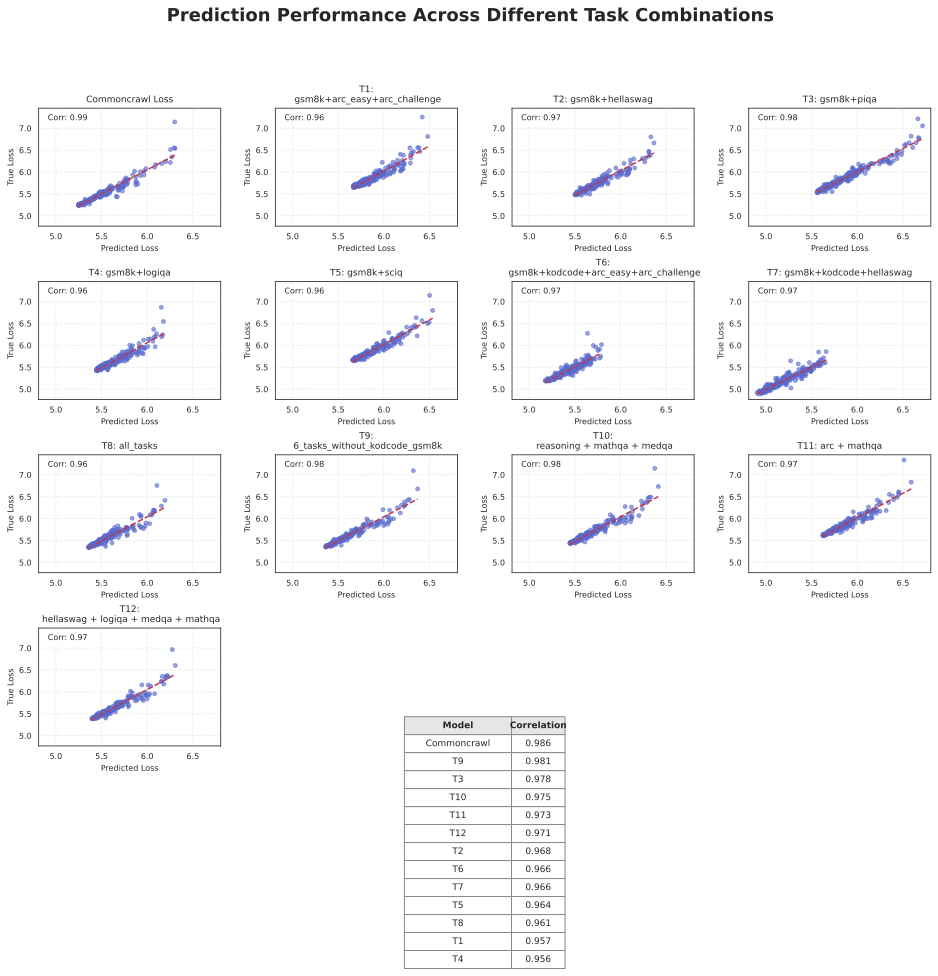

Visualization complete.


In [45]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.stats import spearmanr
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap

# Set basic parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 10

# Function to create visualization for a specific target
def create_subplot(ax, predictor, X_test, y_true, title, y_min=None, y_max=None, x_min=None, x_max=None):
    y_pred = predictor.predict(X_test)
    
    ax.scatter(y_pred, y_true, s=15, color='#5969CB', alpha=0.6)
    
    m, b = np.polyfit(y_pred, y_true, 1)
    x_range = np.linspace(min(y_pred), max(y_pred), 100)
    ax.plot(x_range, m * x_range + b, color='#C3364A', linewidth=1.5, linestyle='dashed')
    
    r, p = spearmanr(y_pred, y_true)
    ax.text(0.05, 0.95, f'Corr: {r:.2f}', transform=ax.transAxes,
            fontsize=8, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Predicted Loss', fontsize=8)
    ax.set_ylabel('True Loss', fontsize=8)
    
    if len(title) > 30:
        parts = title.split(':')
        if len(parts) > 1:
            short_title = parts[0] + ':\n' + parts[1]
        else:
            short_title = title[:15] + '\n' + title[15:]
        ax.set_title(short_title, fontsize=9)
    else:
        ax.set_title(title, fontsize=9)
    
    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min, y_max)
    if x_min is not None and x_max is not None:
        ax.set_xlim(x_min, x_max)
    
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    return r, min(y_pred), max(y_pred), min(y_true), max(y_true)

# Create figure
plt.figure(figsize=(16, 14))

grid = GridSpec(5, 4, figure=plt.gcf(), 
                height_ratios=[1, 1, 1, 1, 0.7],
                hspace=0.5,
                wspace=0.3)

# Track correlations and axis limits
correlations = {}
y_min_global, y_max_global = float('inf'), float('-inf')
x_min_global, x_max_global = float('inf'), float('-inf')

# Calculate global axis limits
commoncrawl_idx = KEY_METRICS.index('metric/task_commoncrawl_val_loss')
predictor = all_predictors['commoncrawl']
y_true = y_test[:, commoncrawl_idx]
y_pred = predictor.predict(X_test)
y_min_global = min(y_min_global, min(y_true))
y_max_global = max(y_max_global, max(y_true))
x_min_global = min(x_min_global, min(y_pred))
x_max_global = max(x_max_global, max(y_pred))

positions = [
    (0, 0), (0, 1), (0, 2), (0, 3),
    (1, 0), (1, 1), (1, 2), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3),
    (3, 0)
]

for (ablation_id, config), pos in zip(ablation_configs.items(), positions):
    ablation_avg_test = compute_reasoning_avg(y_test, config['metrics'])
    predictor = all_predictors[ablation_id]
    y_pred = predictor.predict(X_test)
    
    y_min_global = min(y_min_global, min(ablation_avg_test))
    y_max_global = max(y_max_global, max(ablation_avg_test))
    x_min_global = min(x_min_global, min(y_pred))
    x_max_global = max(x_max_global, max(y_pred))

# Add padding to limits
y_padding = (y_max_global - y_min_global) * 0.05
x_padding = (x_max_global - x_min_global) * 0.05
y_min_global -= y_padding
y_max_global += y_padding
x_min_global -= x_padding
x_max_global += x_padding

# Create Commoncrawl plot
ax = plt.subplot(grid[0, 0])
r, _, _, _, _ = create_subplot(
    ax=ax,
    predictor=all_predictors['commoncrawl'],
    X_test=X_test,
    y_true=y_test[:, commoncrawl_idx],
    title="Commoncrawl Loss",
    y_min=y_min_global, y_max=y_max_global,
    x_min=x_min_global, x_max=x_max_global
)
correlations['Commoncrawl'] = r

positions = [
    (0, 1), (0, 2), (0, 3),
    (1, 0), (1, 1), (1, 2), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3),
    (3, 0)
]

# Create plots for ablation models
for (ablation_id, config), pos in zip(ablation_configs.items(), positions):
    ablation_avg_test = compute_reasoning_avg(y_test, config['metrics'])
    ax = plt.subplot(grid[pos[0], pos[1]])
    
    if len(config['name']) > 50:
        title = f"{ablation_id}"
    else:
        title = f"{ablation_id}: {config['name']}"
    
    r, _, _, _, _ = create_subplot(
        ax=ax,
        predictor=all_predictors[ablation_id],
        X_test=X_test,
        y_true=ablation_avg_test,
        title=title,
        y_min=y_min_global, y_max=y_max_global,
        x_min=x_min_global, x_max=x_max_global
    )
    correlations[ablation_id] = r

# Create table
ax = plt.subplot(grid[4, :])
ax.axis('off')

sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
table_data = [["Model", "Correlation"]]
for model, corr in sorted_correlations:
    table_data.append([model, f"{corr:.3f}"])

table = ax.table(
    cellText=table_data[1:],
    colLabels=table_data[0],
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for (row, col), cell in table.get_celld().items():
    if col == 0:
        cell.set_width(0.12)
    elif col == 1:
        cell.set_width(0.06)
        
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E6E6E6')
    cell.set_edgecolor('#888888')


plt.suptitle("Prediction Performance Across Different Task Combinations", 
            fontsize=18, y=0.98, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('prediction_performance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Visualization complete.")

# Simulate

Sample shape: (100000, 7)

Running simulations for each ablation configuration...

Simulating for commoncrawl...
Top-128 samples shape: (128, 7)

Optimal data mixture for commoncrawl - Commoncrawl:
       Domain  Commoncrawl Weight
        arxiv            0.011382
        books            0.001577
           c4            0.050477
  commoncrawl            0.934739
       github            0.000057
stackexchange            0.000082
    wikipedia            0.001685
train_dw: "0.01,0.00,0.05,0.93,0.00,0.00,0.00"


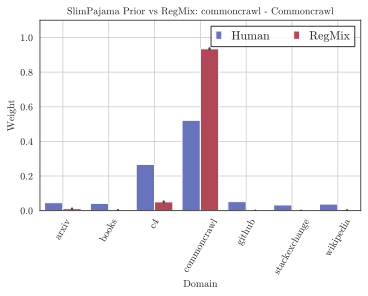


Simulating for T1...
Top-128 samples shape: (128, 7)

Optimal data mixture for T1 - gsm8k+arc_easy+arc_challenge:
       Domain  gsm8k+arc_easy+arc_challenge Weight
        arxiv                             0.007154
        books                             0.019901
           c4                             0.360858
  commoncrawl                             0.610427
       github                             0.000571
stackexchange                             0.000017
    wikipedia                             0.001072
train_dw: "0.01,0.02,0.36,0.61,0.00,0.00,0.00"


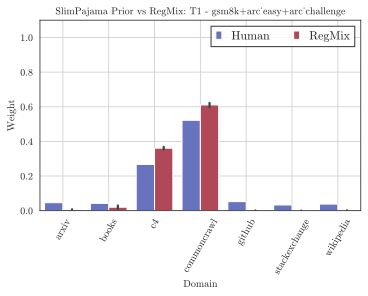


Simulating for T2...
Top-128 samples shape: (128, 7)

Optimal data mixture for T2 - gsm8k+hellaswag:
       Domain  gsm8k+hellaswag Weight
        arxiv                0.013798
        books                0.000380
           c4                0.781158
  commoncrawl                0.191171
       github                0.000357
stackexchange                0.009546
    wikipedia                0.003591
train_dw: "0.01,0.00,0.78,0.19,0.00,0.01,0.00"


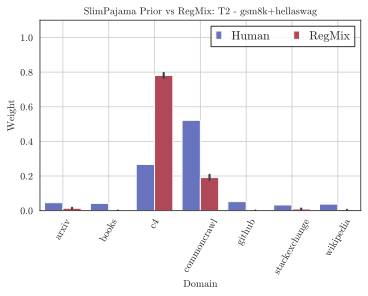


Simulating for T3...


Top-128 samples shape: (128, 7)

Optimal data mixture for T3 - gsm8k+piqa:
       Domain  gsm8k+piqa Weight
        arxiv           0.002517
        books           0.023502
           c4           0.860950
  commoncrawl           0.098077
       github           0.000496
stackexchange           0.008196
    wikipedia           0.006262
train_dw: "0.00,0.02,0.86,0.10,0.00,0.01,0.01"


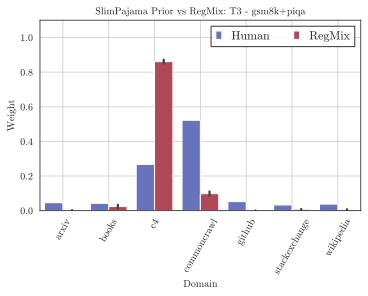


Simulating for T4...
Top-128 samples shape: (128, 7)

Optimal data mixture for T4 - gsm8k+logiqa:
       Domain  gsm8k+logiqa Weight
        arxiv             0.008643
        books             0.010013
           c4             0.764156
  commoncrawl             0.215540
       github             0.000186
stackexchange             0.000014
    wikipedia             0.001448
train_dw: "0.01,0.01,0.76,0.22,0.00,0.00,0.00"


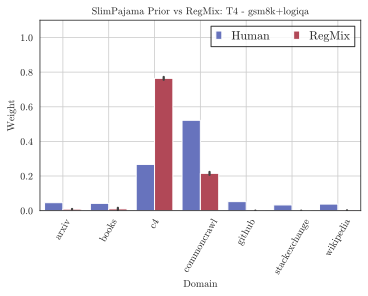


Simulating for T5...
Top-128 samples shape: (128, 7)

Optimal data mixture for T5 - gsm8k+sciq:
       Domain  gsm8k+sciq Weight
        arxiv           0.011190
        books           0.017816
           c4           0.763407
  commoncrawl           0.207406
       github           0.000029
stackexchange           0.000005
    wikipedia           0.000148
train_dw: "0.01,0.02,0.76,0.21,0.00,0.00,0.00"


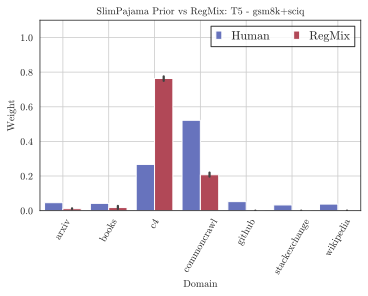


Simulating for T6...
Top-128 samples shape: (128, 7)

Optimal data mixture for T6 - gsm8k+kodcode+arc_easy+arc_challenge:
       Domain  gsm8k+kodcode+arc_easy+arc_challenge Weight
        arxiv                                     0.002913
        books                                     0.010837
           c4                                     0.334374
  commoncrawl                                     0.466894
       github                                     0.099826
stackexchange                                     0.083373
    wikipedia                                     0.001783
train_dw: "0.00,0.01,0.33,0.47,0.10,0.08,0.00"


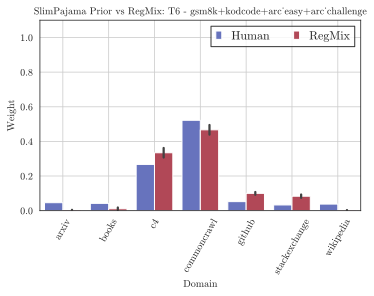


Simulating for T7...
Top-128 samples shape: (128, 7)

Optimal data mixture for T7 - gsm8k+kodcode+hellaswag:
       Domain  gsm8k+kodcode+hellaswag Weight
        arxiv                        0.004323
        books                        0.012323
           c4                        0.580301
  commoncrawl                        0.144050
       github                        0.138052
stackexchange                        0.120047
    wikipedia                        0.000903
train_dw: "0.00,0.01,0.58,0.14,0.14,0.12,0.00"


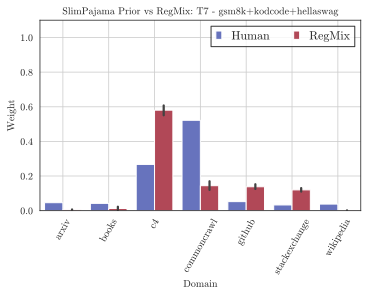


Simulating for T8...
Top-128 samples shape: (128, 7)

Optimal data mixture for T8 - all_tasks:
       Domain  all_tasks Weight
        arxiv          0.002630
        books          0.007098
           c4          0.748645
  commoncrawl          0.177467
       github          0.030647
stackexchange          0.032798
    wikipedia          0.000714
train_dw: "0.00,0.01,0.75,0.18,0.03,0.03,0.00"


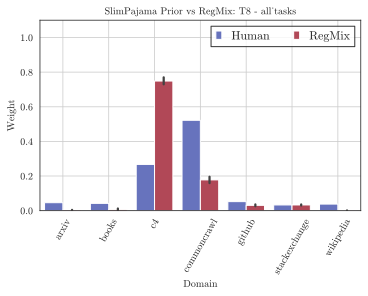


Simulating for T9...
Top-128 samples shape: (128, 7)

Optimal data mixture for T9 - 6_tasks_without_kodcode_gsm8k:
       Domain  6_tasks_without_kodcode_gsm8k Weight
        arxiv                              0.008963
        books                              0.045477
           c4                              0.762915
  commoncrawl                              0.182301
       github                              0.000233
stackexchange                              0.000058
    wikipedia                              0.000054
train_dw: "0.01,0.05,0.76,0.18,0.00,0.00,0.00"


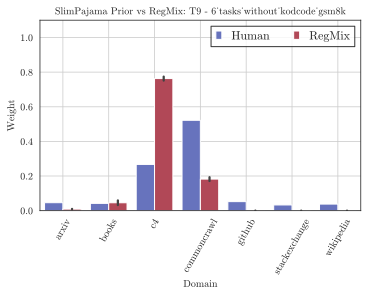


Simulating for T10...
Top-128 samples shape: (128, 7)

Optimal data mixture for T10 - reasoning + mathqamedqa:
       Domain  reasoning + mathqamedqa Weight
        arxiv                        0.004929
        books                        0.102437
           c4                        0.699995
  commoncrawl                        0.192132
       github                        0.000276
stackexchange                        0.000033
    wikipedia                        0.000198
train_dw: "0.00,0.10,0.70,0.19,0.00,0.00,0.00"


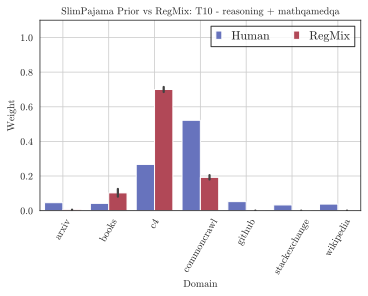


Simulating for T11...
Top-128 samples shape: (128, 7)

Optimal data mixture for T11 - arc + mathqa:
       Domain  arc + mathqa Weight
        arxiv             0.007464
        books             0.018745
           c4             0.324836
  commoncrawl             0.647444
       github             0.000074
stackexchange             0.000324
    wikipedia             0.001113
train_dw: "0.01,0.02,0.32,0.65,0.00,0.00,0.00"


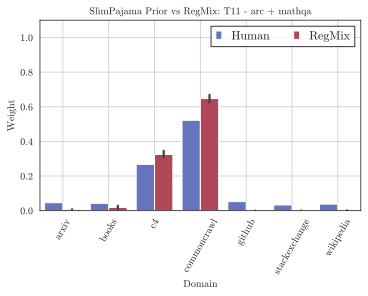


Simulating for T12...
Top-128 samples shape: (128, 7)

Optimal data mixture for T12 - hellaswag + logiqa + medqa + mathqa:
       Domain  hellaswag + logiqa + medqa + mathqa Weight
        arxiv                                    0.007617
        books                                    0.074758
           c4                                    0.746635
  commoncrawl                                    0.168224
       github                                    0.000143
stackexchange                                    0.002396
    wikipedia                                    0.000226
train_dw: "0.01,0.07,0.75,0.17,0.00,0.00,0.00"


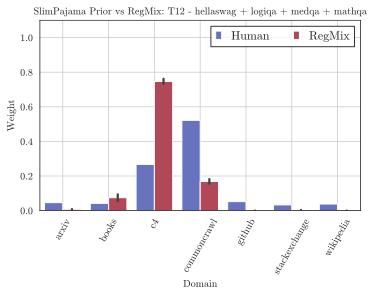

In [ ]:
# Simulation for different metrics with SlimPajama distribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

# Set random seed for reproducibility
np.random.seed(42)

# SlimPajama domain names and distribution
slimpajama_domains = [
    "train_slimpajama_arxiv",
    "train_slimpajama_books",
    "train_slimpajama_c4",
    "train_slimpajama_commoncrawl",
    "train_slimpajama_github", 
    "train_slimpajama_stackexchange",
    "train_slimpajama_wikipedia"
]

# Domain short names for JSON format
domain_short_names = [
    "arxiv",
    "book",
    "c4",
    "cc",
    "github",
    "stackexchange",
    "wikipedia"
]

# SlimPajama original distribution weights
slimpajama_prior_dist = [0.046, 0.042, 0.267, 0.522, 0.052, 0.033, 0.038]

# Generate samples from Dirichlet distribution based on SlimPajama distribution
samples = np.random.dirichlet(np.array(slimpajama_prior_dist) * 1, 100000)
print(f"Sample shape: {samples.shape}")

# Function to simulate and visualize for a specific metric
def simulate_and_visualize(predictor, ablation_id, k=128):
    if ablation_id == 'commoncrawl':
       config = ablation_configs['T8']
       metric_name = 'Commoncrawl'
    else:
        config = ablation_configs[ablation_id]
        metric_name = config['name']
    
    # Predict using the given model
    simulation = predictor.predict(samples)
    
    # Histogram of predictions
    plt.figure(figsize=(10, 6))
    plt.hist(simulation, bins=32)
    plt.xlabel('Pred Loss')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Predicted {metric_name} Loss')
    plt.savefig(f'../misc/slimpajama_hist_{ablation_id.lower()}.png')
    plt.close()
    
    # Find optimal data mixture (top-k samples with lowest predicted loss)
    top_k_indices = np.argsort(simulation)[:k]
    top_k_samples = samples[top_k_indices]
    print(f"Top-{k} samples shape: {top_k_samples.shape}")
    
    optimal_data_mixture = np.mean(top_k_samples, axis=0)
    
    optimal_mix_df = pd.DataFrame({
        'Domain': [domain.split('train_slimpajama_')[-1] for domain in slimpajama_domains],
        f'{metric_name} Weight': optimal_data_mixture
    })

    print(f"\nOptimal data mixture for {ablation_id} - {metric_name}:")
    print(optimal_mix_df.to_string(index=False))
    
    # Generate JSON-ready train_dw string
    train_dw = ",".join([f"{w:.2f}" for w in optimal_data_mixture])
    print(f"train_dw: \"{train_dw}\"")
    
    df = pd.DataFrame(
        data=np.concatenate([np.array([slimpajama_prior_dist]), top_k_samples], axis=0), 
        columns=[domain.split('train_slimpajama_')[-1] for domain in slimpajama_domains]
    )
    df = pd.melt(df)
    df['type'] = (['Human'] + ['RegMix'] * top_k_samples.shape[0]) * len(slimpajama_domains)
    
    plt.rc('axes', unicode_minus=False)
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        'font.serif': 'cmr10',
        'mathtext.fontset': 'cm',
    })
    
    fig, ax = plt.subplots(figsize=(5,4), layout='compressed')
    
    pal = {
        'Human': '#5969CB',
        'RegMix': '#C3364A',
    }
    
    sns.barplot(
        data=df,
        x='variable',
        y='value',
        hue='type',
        palette=pal
    )
    
    ax.tick_params(axis='x', labelrotation=60, labelsize=10)
    ax.legend(
        edgecolor='black',
        fancybox=False,
        prop={'size': 12},
        handlelength=0.5,
        ncol=2,
    )
    
    ax.grid(True)
    ax.set_ylim(0, 1.1, )
    ax.set_xlabel('Domain', fontdict={'size': 10}) 
    ax.set_ylabel('Weight', fontdict={'size': 10})  
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(f'SlimPajama Prior vs RegMix: {ablation_id} - {metric_name}', fontdict={'size': 10})  
    plt.show()
    plt.close()
    
    optimal_mixture_dict = {}
    for domain, weight in zip(slimpajama_domains, optimal_data_mixture):
        optimal_mixture_dict[domain] = float(weight)
    
    optimal_df = pd.DataFrame({
        'Domain': slimpajama_domains,
        'Weight': optimal_data_mixture
    })

    json_config = {
        "dataset": f"slim_ood-{'-'.join(config['metrics'])}",
        "train_domains": ",".join(domain_short_names),
        "tgt_domains": ','.join(config['metrics']),
        "max_steps": 20000,
        "train_dw": train_dw,
        "tgt_dw": None,
        "val_dw": None,
        "max_train_samples": None,
        "max_eval_samples": 5000,
        "max_token_length": 512,
        "seed": 16,
        "preprocessing_num_workers": 2,
        "model_name_or_path": None,
        "model_type": "gpt2",
        "config_overrides": "n_positions=512,n_embd=768,n_layer=12,n_head=12",
        "run_name": f"REGMIX-125M",
        "output_dir": "/mloscratch/homes/glarou/DoGE/regmix/multi_doge/exp",
        "do_train": True,
        "do_eval": True,
        "do_predict": False,
        "learning_rate": 0.0005,
        "weight_decay": 0.01,
        "reweight_train": "None",
        "reweight_tgt": "None",
        "reweight_train_iters": 0,
        "reweight_tgt_iters": 0,
        "ref_model": None,
        "lr_scheduler_name": "linear_warmup_cosine",
        "lr_end": 0.0001,
        "reweight_eps": 0.0,
        "mu_train": 0.001,
        "mu_tgt": 0.0002,
        "max_grad_norm": 5.0,
        "per_device_train_batch_size": 16,
        "warmup_ratio": 0.05,
        "warmup_steps": 500,
        "save_steps": 5000,
        "eval_steps": 500,
        "gradient_accumulation_steps": 2,
        "save_strategy": "steps",
        "evaluation_strategy": "steps",
        "logging_steps": 50,
        "save_total_limit": 10,
        "ddp_find_unused_parameters": False,
        "use_cpu": False,
        "compute_pertoken_losses": False,
        "overwrite_output_dir": False
    }
    
    with open(f'../misc/configs/{ablation_id}-regmix.json', 'w') as f:
        import json
        json.dump(json_config, f, indent=2)
    
    return optimal_data_mixture, optimal_mixture_dict, json_config

print("\nRunning simulations for each ablation configuration...")
optimal_mixtures = {}
optimal_mixture_dicts = {}
json_configs = {}

print(f"\nSimulating for commoncrawl...")
optimal_mixtures['commoncrawl'], optimal_mixture_dicts['commoncrawl'], json_configs['commoncrawl'] = simulate_and_visualize(all_predictors['commoncrawl'], 'commoncrawl')

for ablation_id, predictor in all_predictors.items():
    if ablation_id in ablation_configs:
        print(f"\nSimulating for {ablation_id}...")
        optimal_mixtures[ablation_id], optimal_mixture_dicts[ablation_id], json_configs[ablation_id] = simulate_and_visualize(predictor, ablation_id)



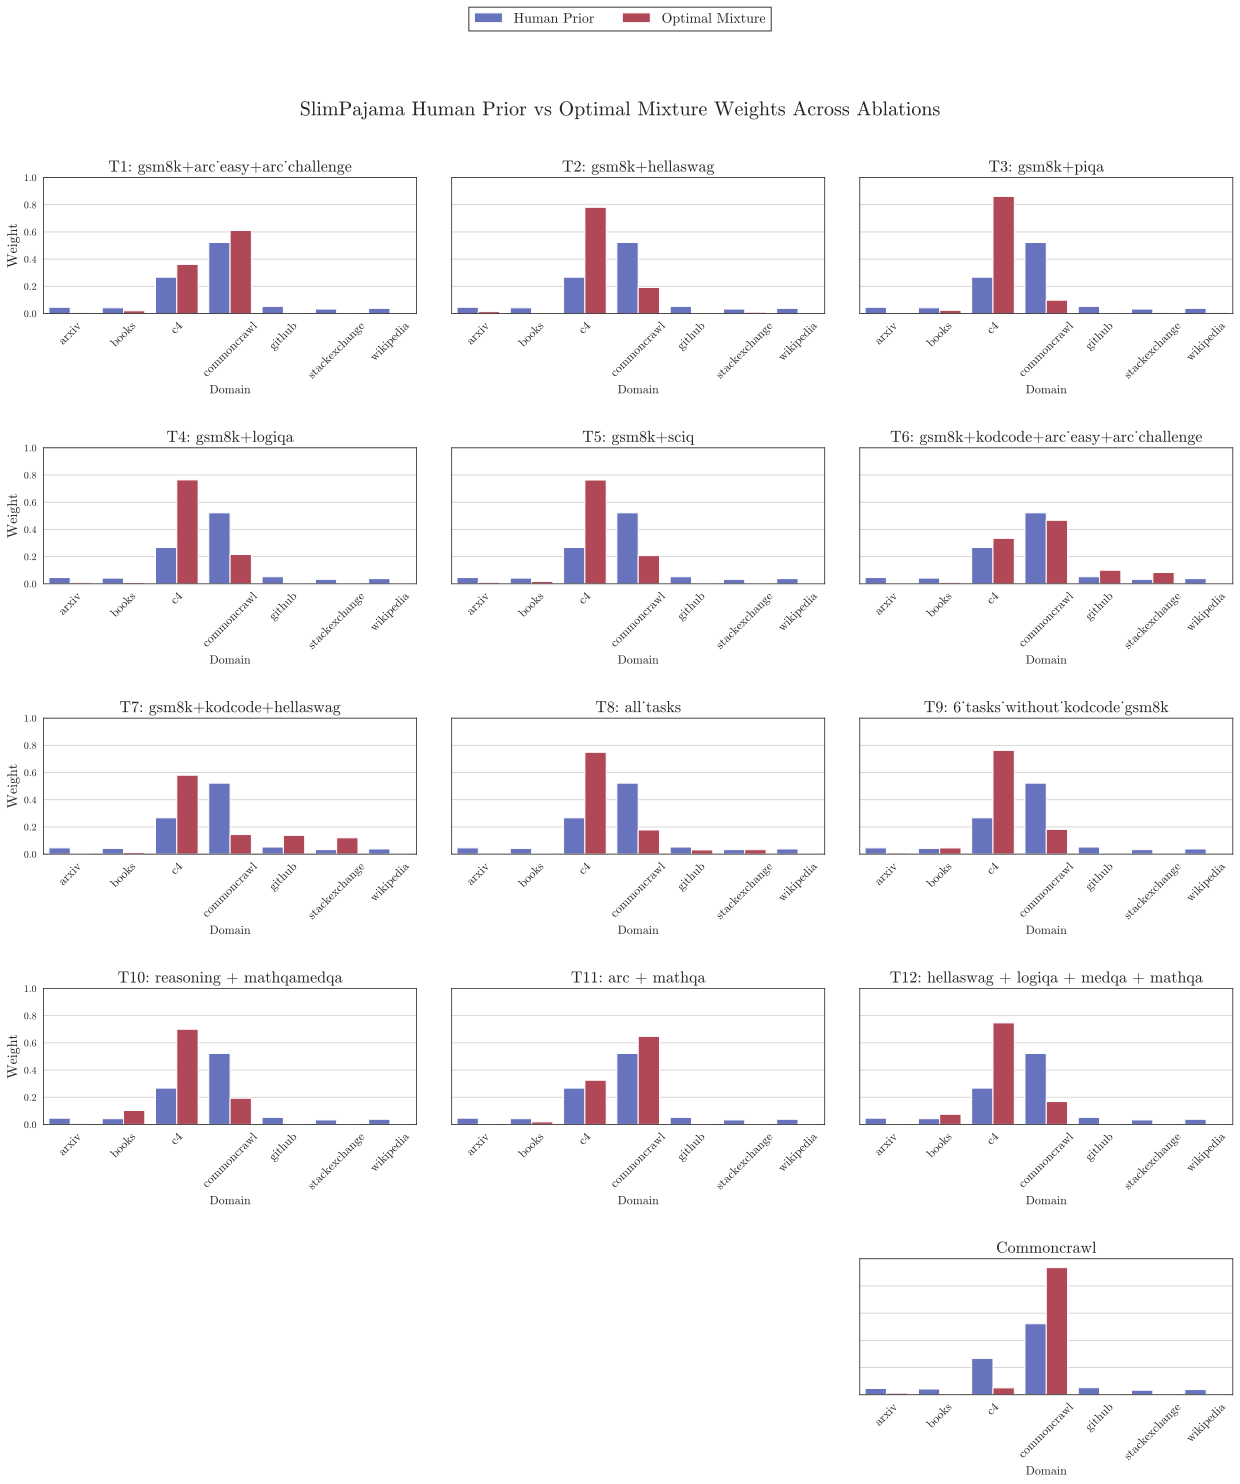

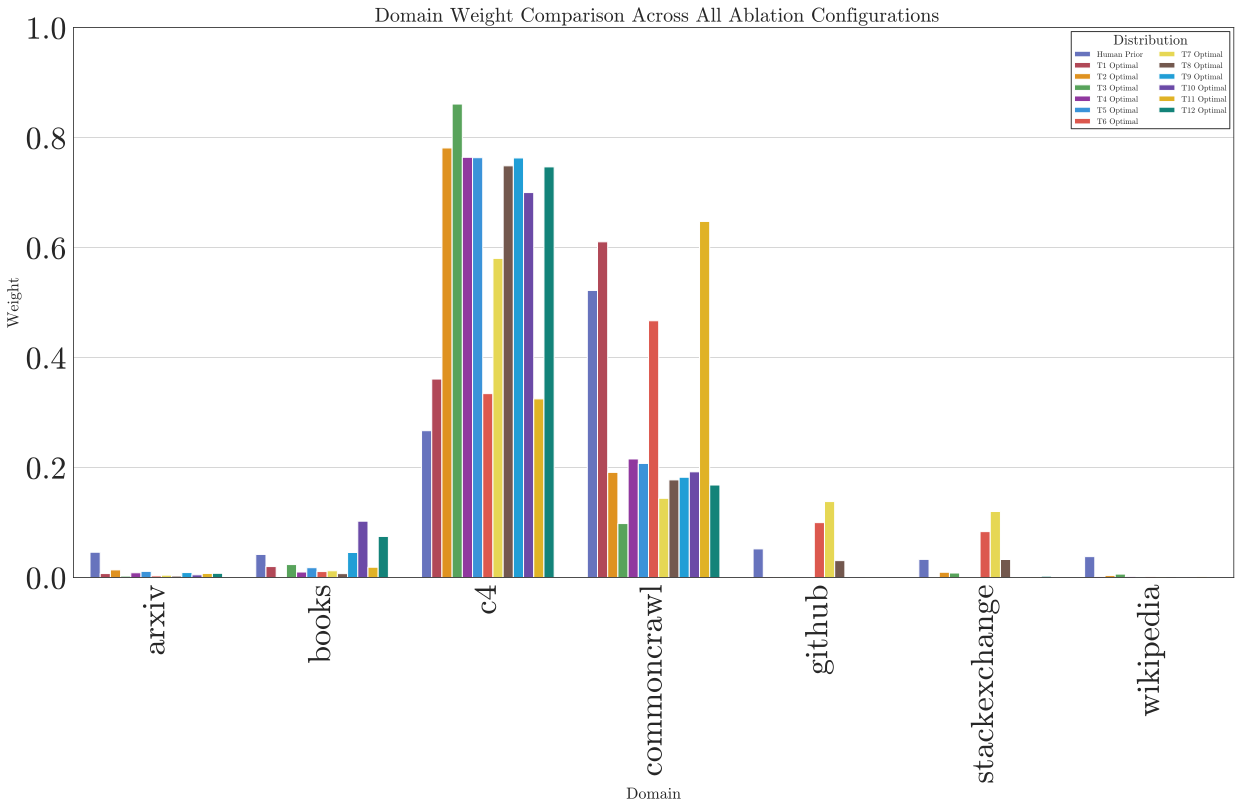

SlimPajama simulation with ablation configurations complete. Config files and plots saved as PNG.


In [ ]:
def plot_all_ablations_comparison():
    """
    Create a single plot with subplots for each ablation configuration compared to "human" weights.
    """
    t_ablations = {k: v for k, v in ablation_configs.items() if k.startswith('T')}
    n_ablations = len(t_ablations) + 1
    
    n_cols = 3
    n_rows = (n_ablations + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharey=True)
    axes = axes.flatten()
    
    # Set up domain labels for x-axis (shorter names for better display)
    domain_labels = [domain.split('train_slimpajama_')[-1] for domain in slimpajama_domains]
    
    pal = {
        'Human Prior': '#5969CB',
        'Optimal Mixture': '#C3364A',
    }
    
    
    # Plot each ablation configuration
    for i, (ablation_id, config) in enumerate(t_ablations.items()):
        if i < len(axes) and ablation_id in optimal_mixtures:
            ax = axes[i]
            
            plot_df = pd.DataFrame({
                'Domain': domain_labels,
                'Human Prior': slimpajama_prior_dist,
                'Optimal Mixture': optimal_mixtures[ablation_id]
            })
            
            plot_df_melted = pd.melt(plot_df, id_vars=['Domain'], 
                                    value_vars=['Human Prior', 'Optimal Mixture'], 
                                    var_name='Distribution', value_name='Weight')
            
            sns.barplot(data=plot_df_melted, x='Domain', y='Weight', hue='Distribution', 
                        palette=pal, ax=ax)
            
            ax.set_title(f'{ablation_id}: {config["name"]}', fontsize=16)
            ax.set_ylim(0, 1)  
            ax.tick_params(axis='x', rotation=45, labelsize=12)
            ax.tick_params(axis='y', labelsize=10)
            # Only show y-label on the leftmost subplots
            if i % n_cols == 0:
                ax.set_ylabel('Weight', fontsize=14)
            else:
                ax.set_ylabel('')
            
            ax.set_xlabel('Domain', fontsize=12)
            ax.grid(True, axis='y')

    # add commoncrawl
    ax = axes[-1]  
    plot_df = pd.DataFrame({
        'Domain': domain_labels,
        'Human Prior': slimpajama_prior_dist,
        'Optimal Mixture': optimal_mixtures['commoncrawl']
    })
    plot_df_melted = pd.melt(plot_df, id_vars=['Domain'],
                            value_vars=['Human Prior', 'Optimal Mixture'], 
                            var_name='Distribution', value_name='Weight')
    sns.barplot(data=plot_df_melted, x='Domain', y='Weight', hue='Distribution',
                palette=pal, ax=ax)
    ax.set_title(f'Commoncrawl', fontsize=16)
    ax.set_ylim(0, 1)  
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylabel('Weight', fontsize=14)
    ax.set_xlabel('Domain', fontsize=12)
    ax.grid(True, axis='y')
    

    # Hide any unused subplots
    for i in range(len(t_ablations), len(axes)):
        axes[i].set_visible(False)
    axes[-1].set_visible(True)  # Ensure the last one is visible
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=14, 
               fancybox=False, edgecolor='black', bbox_to_anchor=(0.5, 1.05))
    
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    
    fig.suptitle('SlimPajama Human Prior vs Optimal Mixture Weights Across Ablations', fontsize=20)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('../misc/all_ablations_comparison.png', 
                bbox_inches='tight', pad_inches=0.1, dpi=300)
    
    plt.close()

def plot_all_weights_in_single_barplot():
    """
    Create a single barplot showing all the different domain weights for each configuration.
    """
    domain_labels = [domain.split('train_slimpajama_')[-1] for domain in slimpajama_domains]
    
    t_ablations = {k: v for k, v in ablation_configs.items() if k.startswith('T')}
    
    plot_data = {'Domain': [], 'Distribution': [], 'Weight': []}
    
    for domain, weight in zip(domain_labels, slimpajama_prior_dist):
        plot_data['Domain'].append(domain)
        plot_data['Distribution'].append('Human Prior')
        plot_data['Weight'].append(weight)
    
    for ablation_id, config in t_ablations.items():
        if ablation_id in optimal_mixtures:
            for domain, weight in zip(domain_labels, optimal_mixtures[ablation_id]):
                plot_data['Domain'].append(domain)
                plot_data['Distribution'].append(f'{ablation_id} Optimal')
                plot_data['Weight'].append(weight)
    
    plot_df = pd.DataFrame(plot_data)
    
    distributions = ['Human Prior'] + [f'{aid} Optimal' for aid in t_ablations.keys() if aid in optimal_mixtures]
    colors = ['#5969CB', '#C3364A', '#FF9800', '#4CAF50', '#9C27B0', 
              '#2196F3', '#F44336', '#FFEB3B', '#795548', '#03A9F4', 
              '#673AB7', '#FFC107', '#009688', '#E91E63']
    pal = {dist: color for dist, color in zip(distributions, colors[:len(distributions)])}
    
    plt.figure(figsize=(10, 9))
    
    ax = sns.barplot(data=plot_df, x='Domain', y='Weight', hue='Distribution', 
                    palette=pal)
    
    ax.set_title(' Domain Weight Comparison Across All Ablation Configurations', fontsize=20)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Domain', fontsize=16)
    ax.set_ylabel('Weight', fontsize=16)
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True, axis='y')
    
    plt.legend(title='Distribution', fontsize=8, title_fontsize=14,
               edgecolor='black', fancybox=False, ncol=2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    plt.savefig('../misc/all_optimal_weights_comparison.png', 
                bbox_inches='tight', pad_inches=0.1, dpi=300)
    
    plt.close()

plot_all_ablations_comparison()
plot_all_weights_in_single_barplot()

print("SlimPajama simulation with ablation configurations complete. Config files and plots saved as PNG.")